# TODO
1. Compare small (384) vs large (768) embedding vectors.
2. Tune the number of Annoy trees.
3. More exploration with community detection algorithms.
4. When fine-tuning the SimCSE model, experiment with max-pooling rather than CLS-pooling.
5. Should we always keen theme-level tokens in our dictionary?

In [1]:
RANDOM_SEED = 42                 # For repeatable experiments
REBUILD = True                   # Set to TRUE to force a rebuild of the core transformer, embeddings, Annoy index and sim-graph

# Data extraction
PROJECT_SAMPLE_SIZE = 100000     # The number of source tweets we'll retrieve

# Pre-processing 
MAX_HASHTAGS_BEFORE_REMOVAL = 0  # If there are more than this many hashtags in a tweet, remove them all.

# Dictionary-building
MIN_TOKEN_COUNT = 20             # Minimum # token occurances for a dictionary entry
MAX_TOKEN_FREQ = 0.25            # When building the token dictionary, any token appearing in more than this % of documents is pruned

# Fine-tuning
N_TRAINING_EPOCHS = 2            # Number of epochs of fine-tuning for the transformer.
MAX_SEQ_LEN = 100                # Large enough for the vast majority of tweets.

# Indexing
NUM_ANNOY_TREES = 1              # How many NN trees to build.  More trees = more accurate recall.

# Topic Graph
MIN_SIM_SCORE = 0.45             # Minimum similarity between embedding vectors to yield an edge in the topic graph.
MIN_CLUSTER_SIZE = 20            # Discard topic clusters with fewer than this number of members.

# Rule generation
RULE_UNDERSAMPLING_RATIO = 0.1   # When extracting rules, under-sample negative values according to this ratio.
NUM_TERMS_TO_CONSIDER = 20       # When generating rules, start with a subset of this many tokens.
MIN_EXAMPLES_PER_RULE = 20       # Each subrule needs to match at least this many positive examples.
MIN_CONFIDENCE = 0.9             # Minimum confidence of a subrule if it is to be returned.
MAX_FREQ_TOKENSET_SIZE = 100     # Build frequent tokensets no larger than this.
MAX_SUBRULE_ATTEMPTS = 20        # Cap on the number of attempts to build subrules.

In [2]:
DATASET_METADATA = {
    'NAME':       'PartyGate vs. Cost of Living (UK Decision-Makers)',
    'PROJECT_ID': 71,
    'FROM_DATE':  '2022-05-08',
    'TO_DATE':    '2022-06-09',
    'SOURCE':     "extract_uk_decision_makers_partygate_9"
}

In [3]:
import seaborn as sns

sns.set(rc={'figure.figsize':(20,10)})

import pandas as pd

pd.set_option('display.max_colwidth', 150)

In [4]:
db_config = {
    'host':      "localhost", 
    'port':      5432, 
    'database':  "deepseer", 
    'user':      "tweetypy", 
    #'password':  "wQ121zvYWympD2dC25kP" # UAT
    'password':  "dwJa37s67418tzeS" # PROD
}

# Load Raw Data

If we can find a previously extracted raw dataset with the right name, then load that; otherwise extract the data from Aurora.

In [5]:
import psycopg2
import numpy as np
import warnings
import pandas as pd

def extract_data_from_aurora(DATASET_METADATA):
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        with psycopg2.connect(**db_config) as conn:
            df = pd.read_sql(f"""
                select 
                    distinct source_tweet_text
                from 
                    deepseer_tweets.{DATASET_METADATA['SOURCE']}
                where 
                    {DATASET_METADATA['PROJECT_ID']} = any(relevant_projects)
                    and created_at between '{DATASET_METADATA['FROM_DATE']}'::timestamp and '{DATASET_METADATA['TO_DATE']}'::timestamp
                limit 
                    {PROJECT_SAMPLE_SIZE}
            """, conn)    
    
    return df

In [6]:
try:
    df = pd.read_csv(f"./data/raw/{DATASET_METADATA['NAME']}.csv").dropna()
except FileNotFoundError:
    df = extract_data_from_aurora(DATASET_METADATA)
    df.to_csv(f"./data/raw/{DATASET_METADATA['NAME']}.csv", index=False)

print(f"Dataset contains [{df.shape[0]}] rows.")

Dataset contains [100000] rows.


# Data Preprocessing

We do a number of things here:

1. Minimally clean the data, making it suitable for BERT finetuning.
2. Tokenize the data, for use in narrative rule generation.
3. Map the tokens to a dictionary and compute the bag-of-words representation for each tweet.

### Strip URLs

First find all of the t.co URLs and place them into a new column.  Remove them from the tweet text.

In [7]:
import re

URLS_RE = re.compile(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+")

df['urls'] = df.source_tweet_text.apply(URLS_RE.findall)

In [8]:
# Remove the URLs from the tweet text

def remove_urls(row):
    source_tweet_text = row.source_tweet_text
    for u in row.urls:
         source_tweet_text = source_tweet_text.replace(u, '')
    return source_tweet_text.strip()

df.source_tweet_text = df.apply(remove_urls, axis='columns')

### Basic Text Preprocessing

In [9]:
from textacy import preprocessing
from functools import partial

replace_user_handles = partial(preprocessing.replace.user_handles, repl='')
replace_urls = partial(preprocessing.replace.urls, repl='')
replace_hashtags = partial(preprocessing.replace.hashtags, repl='')
remove_ampersand = lambda text: text.replace('&amp', '')
remove_newline = lambda text: text.replace('\n', ' ')
replace_emojis = partial(preprocessing.replace.emojis, repl='')
delete_chars = lambda text: text.replace("'", "").replace("-", "")

# def remove_at_mentions(text):
#     tokens = text.split(' ')
#     filtered_tokens = [t for t in tokens if not t[0] == '@']
#     return ' '.join(tokens)

preproc = preprocessing.make_pipeline(
    preprocessing.normalize.bullet_points,
    preprocessing.normalize.quotation_marks,
    preprocessing.normalize.whitespace,
    preprocessing.normalize.unicode,
    preprocessing.remove.accents,
    replace_urls,
    remove_ampersand,
    delete_chars,    
    replace_user_handles,
    preprocessing.remove.punctuation,    
    replace_emojis,
    remove_newline,
    preprocessing.remove.brackets,
    preprocessing.normalize.whitespace
)

preproc_no_hashtags = preprocessing.make_pipeline(
    preprocessing.normalize.bullet_points,
    preprocessing.normalize.quotation_marks,
    preprocessing.normalize.whitespace,
    preprocessing.normalize.unicode,
    preprocessing.remove.accents,
    replace_urls,
    remove_ampersand,    
    # Replace hashtags with the empty string before we handle punctuation
    replace_hashtags,
    replace_user_handles,
    delete_chars,
    preprocessing.remove.punctuation,
    replace_emojis,
    remove_newline,
    preprocessing.remove.brackets,
    preprocessing.normalize.whitespace
)

In [10]:
def preprocess(text, hashtag_threshold=MAX_HASHTAGS_BEFORE_REMOVAL):
    if text.count("#") > hashtag_threshold:
        return preproc_no_hashtags(text)
    else:
        return preproc(text)

In [11]:
df['preprocessed_text'] = [preprocess(t) for t in df.source_tweet_text.values]

In [15]:
# Preprocessing will result in duplicates appearing.  We'll deduplicate here.
df = df[['preprocessed_text']].drop_duplicates()
df = df[~df.preprocessed_text.isna()]
print(f"Deduplicated dataset contains [{df.shape[0]}] rows.")

Deduplicated dataset contains [90787] rows.


In [16]:
# Add an ID column to make it easier to reference the rows later.
df['id'] = range(df.shape[0])

In [17]:
# We'll use this number repeatedly
n_docs = df.shape[0]

### Tokenize and Stem the tweets

In [18]:
from gensim.parsing.porter import PorterStemmer
from gensim.parsing.preprocessing import remove_stopwords

stemmer = PorterStemmer()

def tokenize(text):
    for word in remove_stopwords(text).split(' '):
        yield stemmer.stem(word)

In [19]:
df['tokenized'] = df.preprocessed_text.apply(lambda text: list(tokenize(text)))

In [20]:
from gensim.models.tfidfmodel import TfidfModel
from gensim.corpora import Dictionary

dct = Dictionary(df.tokenized)

print(f"Unfiltered dct has {len(dct)} entries.")

dct.filter_extremes(
    no_below=MIN_TOKEN_COUNT, 
    no_above=MAX_TOKEN_FREQ, 
    # TODO: should we keep theme-level tokens?
    #keep_tokens=???
)

print(f"Filtered dct has {len(dct)} entries.")

df['bow'] = df.tokenized.apply(dct.doc2bow)

# n.b. use of the 'bnn' value means we evaluate TF=Binary, IDF=None, Normalisation=None
# Therefore we have essentially just computed the Binary Term Frequencies
tfidf_model = TfidfModel(df.bow.values.tolist(), smartirs='bnn')

# Since the values are all 1 we just need the token keys
df['btf'] = df.bow.apply(lambda x: [token_key for token_key, btf in tfidf_model[x]])

Unfiltered dct has 40435 entries.
Filtered dct has 5663 entries.


In [21]:
# Vocabulary size
V = len(dct.items())

In [22]:
# Weird bug in Gensim.  Dictionary doesn't initialise properly unless we address it first!
dct[0]

'40'

### Function `calc_tfidf`

Construct a TF-IDF matix.  We'll use this function later on.

Actually this is a binary-term matrix, so each value is a $1$ or a $0$.

We could modify this code to generate a sparse matrix instead.  The SVD algorithm will support that.

In [23]:
from scipy.sparse import coo_matrix
from itertools import count

def calc_tfidf(df, print_=True):

    data = [1] * sum([len(vec) for vec in df.btf])
    j = [token_key for vec in df.btf for token_key in vec]
    i = [idx for idx, vec in zip(count(), df.btf) for token_key in vec]

    Z = coo_matrix((data, (i,j)))

    if print_:
        print(f"TF-IDF matrix has dimensions: {Z.shape}")
        
    return Z.todense()

# Embedding

## Finetune the SimCSE transformer

The SimCSE model (https://arxiv.org/abs/2104.08821) works as follows:

1. Start with a pretrained BERT transformer model to obtain fixed-dimensional word embeddings.  We use DistilRoBERTa (https://huggingface.co/docs/transformers/model_doc/distilbert) as the base. This is based on the RoBERTa model which only trains against the Masked Language Model (MLM) objective.  Dropout is set to 0.1 as standard.
2. Stack a mean-pooling layer on top.  (The `all-distilroberta-v1` model was trained using mean-pooling, not the CLS token, to generate document embeddings.)
3. Training examples consist of pairs of the same document (dropout masks are be applied separately, and randomly, to each item in a pair).
4. Use the Multiple Negatives Ranking (MNR) Loss.  For example $x_i$ in a batch of $K$ input pairs the loss function evaluates:

\begin{align}
\mathcal{l}_i &= - \text{log } \mathbf{P}\left(x_i | x_i\right) \\
& \approx -\text{log } \left( \frac{e^{\text{sim}\left(z_i^{\left(1\right)}, z_i^{\left(2\right)}\right)}}{\sum_{k=1}^{K}e^{\text{sim}\left(z_i^{\left(1\right)}, z_k^{\left(2\right)}\right)}} \right) \\
&\approx -\text{sim}\left(z_i^{\left(1\right)}, z_i^{\left(2\right)}\right) + \text{log } \left(\sum_{k=1}^{K}e^{\text{sim}\left(z_i^{\left(1\right)}, z_k^{\left(2\right)}\right)} \right)
\end{align}
Where $\text{sim}$ is the cosine similarity function, $z_i$ is the mean-embedding vector for example $x_i$ and the superscripts $z_i^{\left(1\right)}$ and $z_i^{\left(2\right)}$ denote the dropout masks applied to the first and second elements of the input pair, respectively.  (MNR loss is therefore effectively just a form of cross-entropy loss.)

In [313]:
from sentence_transformers import SentenceTransformer, InputExample
from sentence_transformers import models, losses
from torch.utils.data import DataLoader

def finetune_simcse(DATASET_METADATA):

    # Cased version of DistilRoBERTa.
    model_name = 'sentence-transformers/all-distilroberta-v1'

    word_embedding_model = models.Transformer(model_name, max_seq_length=32)

    pooling_model = models.Pooling(
        word_embedding_dimension=word_embedding_model.get_word_embedding_dimension(),
        pooling_mode='mean'
    )

    model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

    # SimCSE uses masked pairs of inputs.
    train_data = [InputExample(texts=[doc, doc]) for doc in df.preprocessed_text.to_numpy()]

    # Batch the data.  Larger batches make the MNR loss more accurate.
    # Shuffling super-important, otherwise the MNR loss will not work 
    # (because we risk near identical tweets appearing next to each other in the dataset).
    train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)

    train_loss = losses.MultipleNegativesRankingLoss(model)
    
    model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        epochs=N_TRAINING_EPOCHS,
        show_progress_bar=True
    )
    
    model.save(f"./transformers/model_[{DATASET_METADATA['NAME']}]")
    
    return model

In [314]:
# Load or finetune a SimCSE model

from sentence_transformers import SentenceTransformer

try:
    if REBUILD:
        raise ValueError()
    else:
        print("Loading transformer model")
        model = SentenceTransformer(f"./transformers/model_[{DATASET_METADATA['NAME']}]")
except ValueError:
    print("Fine-tuning using SimCSE task")    
    model = finetune_simcse(DATASET_METADATA)

Fine-tuning using SimCSE task


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/710 [00:00<?, ?it/s]

Iteration:   0%|          | 0/710 [00:00<?, ?it/s]

## Generate the embeddings

We wrap the document embeddings in Gensim's `KeyedVectors` class.  This is because the next step (indexing) expects this.

In [315]:
# Gensim's Annoy API requires the use of keyed vectors. 
from gensim.models.keyedvectors import KeyedVectors

try:
    if REBUILD:
        raise FileNotFoundError()
    else:
        print("Loading Embedding")        
        embedding = KeyedVectors.load(f"./embeddings/{DATASET_METADATA['NAME']}__x768")
except FileNotFoundError:
    print("Generating Embedding")
    embedding = KeyedVectors(model[1].word_embedding_dimension)
    embedding.add_vectors(
        keys=range(n_docs),
        weights=model.encode(
            df.preprocessed_text.to_numpy(), 
            show_progress_bar=True, 
            convert_to_numpy=True, 
            device='cuda'
        )
    )
    embedding.save(f"./embeddings/{DATASET_METADATA['NAME']}__x768")

Generating Embedding


Batches:   0%|          | 0/2838 [00:00<?, ?it/s]

# Similarity Search

We proceed as follows:

Construct an efficient index for performing similarity search over our embedding vectors.  I have chosen Approximate Nearest Neighbours (A-NN), implemented by the `annoy` package (https://github.com/spotify/annoy), which comes packaged with `gensim`.  It has the following properties:
  1. It is stochastic (i.e. it doesn't guarantee the same - or a complete - similarity set each time you run it).  However, given subsequent steps this should have minimal impact on the clustering results.
  2. `annoy`, specifically, is fast - making it well suited to prototyping.
  3. Nearest Neighbours, in general, is simple.  For implementing at scale we might want to compare A-NN with Locality Sensitive Hashing.
  4. The default distance metric used by `annoy` is Cosine similarity, which is the same metric as was used during SimCSE training.  It'll also perform better than, say the Euclidean distance on a length 768 dense vector.

In [316]:
from gensim.similarities.annoy import AnnoyIndexer

annoy_index = AnnoyIndexer()

try:
    if REBUILD:
        raise OSError()
    else:
        print("Loading Annoy Index")
        annoy_index.load(f"./annoy_indexes/{DATASET_METADATA['NAME']}.annoy")
except OSError:
    print("Creating Annoy Index")
    annoy_index = AnnoyIndexer(embedding, num_trees=NUM_ANNOY_TREES)
    annoy_index.save(f"./annoy_indexes/{DATASET_METADATA['NAME']}.annoy")

Creating Annoy Index


### Exploratory test: use the index to find examples of similar documents.

In [317]:
import numpy as np
from tqdm import tqdm

def most_similar_to_random_tweet(df, embedding, annoy_index, min_sim_score, min_matches=1, n_trials=100):
    for i in tqdm(range(n_trials)):
        doc_id = np.random.choice(df.shape[0])
        vector = embedding.get_vector(doc_id)
        dists = embedding.most_similar([vector], indexer=annoy_index)
        dists = [(doc_id, score) for doc_id, score in dists if score >= min_sim_score and score < 1.0]
        
        if len(dists) >= min_matches:
            print(df.preprocessed_text.values[doc_id])
            print("+++")            
            
            for doc_id, score in dists:
                doc_id = int(doc_id)
                print(df.preprocessed_text.values[doc_id])
                print(score)
                print("***")
            return None
    print(f"{n_trials} tweets sampled but none had >= {min_matches} matches with score >= {min_sim_score}.")

In [318]:
most_similar_to_random_tweet(df, embedding, annoy_index, 0.4, 2, 100)

  0%|                                                                                                                               | 0/100 [00:00<?, ?it/s]

A person called Nawaz sharif sitting in the UK has stolen billions of dollars from the Pakistani people The UK is a hub of illgotten wealth
+++
UK is one of the biggest beneficiary of LOOTED WEALTH of CORRUPT POLITICIANS of Pakistan plus assisting them in money laundering and legal protection lets not even start on MI6 terrorism in Karachi via Altaf Hussain for decades
0.4911448359489441
***
The people of UK stole trillions of dollars of wealth from india and your aid is worth peanuts
0.48560696840286255
***
Bought and paid for by UK taxpayers money you globalist fraud
0.46781784296035767
***
You harbor criminals and money launderers for their stolen money Shame on UK govt
0.45808184146881104
***
Lousy hypocrite You do NOTHING for the British people except WASTE our money steal it by inflation Scoundrel of the worst kind
0.4579402804374695
***
Shehbaz shareef is imported corrupt PM imposed on us And his bro NS is corrupt stole our money and hiding in UK Both have nothing to do with pk


# Build the Similarity Graph

Construct a graph where vertices are tweets and edges represent index similarity (for closely related tweets).

In [319]:
from tqdm import tqdm
import networkx as nx
from networkx import NetworkXError

def generate_graph(word_vectors, index, min_sim_score=0.5):
    
    # Edge iterator for the graph
    def gen_edges():

        for src_id in tqdm(range(len(word_vectors.index_to_key))):       
            vector = word_vectors.get_vector(src_id)
            dists = word_vectors.most_similar([vector], indexer=index)

            for tgt_id, score in dists:
                if int(tgt_id) > src_id and score > min_sim_score:
                    yield (src_id, int(tgt_id), score)
                    
    
    G = nx.Graph()

    # Add edges.
    for i,j,w in gen_edges():
        G.add_edge(i, j, weight=w)

    # Now remove self-edges. (Every document is most similar to itself, but this is not interesting.)
    G.remove_edges_from(nx.selfloop_edges(G))    
    
    for idx, doc in tqdm(enumerate(df.preprocessed_text)):
        G.add_node(idx, tokens=doc)

    print(f"Vertices: [{G.number_of_nodes()}], Edges: [{G.number_of_edges()}]")

    G.remove_nodes_from(list(nx.isolates(G)))
    print(f"After dropping singletons: Vertices: [{G.number_of_nodes()}], Edges: [{G.number_of_edges()}]")    
    
    return G

In [320]:
import networkx as nx

try:
    if REBUILD:
        raise FileNotFoundError()
    else:
        print("Loading Graph")
        G = nx.readwrite.gpickle.read_gpickle(f"./graphs/{DATASET_METADATA['NAME']}_networkx.gpickle")
except FileNotFoundError:
    print("Generating Graph")
    G = generate_graph(embedding, annoy_index, min_sim_score=MIN_SIM_SCORE)
    nx.readwrite.gpickle.write_gpickle(G, f"./graphs/{DATASET_METADATA['NAME']}_networkx.gpickle")

Generating Graph


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90787/90787 [01:04<00:00, 1406.63it/s]
90787it [00:00, 731465.06it/s]


Vertices: [90787], Edges: [169810]
After dropping singletons: Vertices: [61079], Edges: [169810]


# Find Clusters of Similar Tweets

Using one of my "go-to" community detection methods, Label Propagation (https://arxiv.org/abs/0803.0476).  Selected because it is fast and there is a simple-to-implement version for large graphs in a distributed setting, which would help us with productionisation.

### Label Propogation

In [321]:
from cdlib.algorithms import label_propagation
from collections import namedtuple
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

Metric = namedtuple('Metric', 'C Q r')


def cluster_label_propogation(G, verbose=False):

    clusters = label_propagation(G)
    Q = clusters.newman_girvan_modularity().score
    C = len(clusters.communities)

    # Singletons are not considered to be clusters and will be removed in subsequent steps.
    n_tweets = G.number_of_nodes()
    n_clusters = len([c for c in clusters.communities if len(c) > 1])
    largest_cluster = max([len(c) for c in clusters.communities])
    n_assigned = sum([len(c) for c in clusters.communities if len(c) > 1])
    n_unassigned = n_tweets - n_assigned

    if verbose:
        print(f"""
            There are [{n_tweets}] tweets.
            [{n_clusters}] clusters were identified.
            The largest has [{largest_cluster}] members.
            [{n_assigned}] tweets assigned to a cluster.
            [{n_unassigned}] tweets were not assigned to a cluster.
            Modularity is {np.round(Q, 2)}.
        """)
    
    return clusters

In [322]:
clusters = cluster_label_propogation(G, verbose=True)


            There are [61079] tweets.
            [9225] clusters were identified.
            The largest has [439] members.
            [61079] tweets assigned to a cluster.
            [0] tweets were not assigned to a cluster.
            Modularity is 0.77.
        


For the purposes of this notebook we're going to drop small topics.  In a production context we need to consider what we do:
- If we drop small topics then we might lose important information: e.g. if a topic grows over time then we'd miss out on it's genesis.
- If we generate all topics then we might create too much data.  After all, the large majority of small topics will never be used in a report or even viewed by a human.

In [323]:
clusters = [c for c in clusters.communities if len(c) >= MIN_CLUSTER_SIZE]
cluster_sizes = pd.Series({k: len(v) for k,v in enumerate(clusters)})

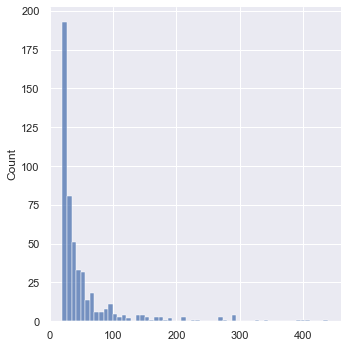

In [324]:
from seaborn import displot

displot(cluster_sizes)

### Exploratory test: print samples from clusters

In [325]:
def print_cluster(clusters, cluster_sizes, sample_size=5, cluster_id=None):
    
    if not cluster_id:
        cluster_id = np.random.choice(cluster_sizes.index)

    print(f"Cluster [{cluster_id}] has [{cluster_sizes[cluster_id]}] members.")
    print("+++")

    cluster = clusters[cluster_id]
    sample = np.random.choice(cluster, min(sample_size, len(cluster)))    

    for doc_id in sample:
        print(df.preprocessed_text.values[doc_id])
        print("***")

In [326]:
print_cluster(clusters, cluster_sizes)

Cluster [474] has [21] members.
+++
As of 5 30pm 2nd June 2022 owes our NHS £105 599 billion
***
As of 2 30am 30th May 2022 owes our NHS £105 423 billion
***
As of 5 30pm 2nd June 2022 owes our NHS £105 599 billion
***
As of 2 30pm 3rd June 2022 owes our NHS £105 642 billion
***
As of 2 30am 20th May 2022 owes our NHS £104 936 billion
***


# Derive Filter Rules

### Reducing the Computational Difficulty

The computational challenge with extracting rules is that there are a large number of tokens, $v \in V$, in our vocabulary.  Searching through them for combinations which isolate a topic, $t$ from non-topic tweets involves evaluating a combinatatorial space that grows as $V!$.

We have a data matrix $M \in \mathbb{N}^{N \times V}$ where $M_{i,j}$ represents the number of times token $j$ occurs in document $i$.

Imagine we partition $M$ into two matrices, $X$ and $Z$, where $X$ contains all examples belonging to a particular topic, and $Z$ everything else.

The matrix $X^{T}X$ therefore holds covariance information about the tokens.  It is positive definite, by construction and therefore has a valid eigendecomposition $X^{T}X = Q \Lambda Q^{-1}$.

The leading eigenvector of $Q$ should be useful as a compressed representation of $X$.

To find it we can perform an efficient, truncated Singular Value Decomposition on $X$, using the fact that:

\begin{align}
X &= U D V^T & & \text{Singular Value Decomposition} \\
\therefore X^{T}X &= \left(U D V^T\right)^T \left(U D V^T\right) \\
&= \left(V D U^T\right)\left(U D V^T\right) \\
&= V D I D V^T & & \text{Because $U$ is orthonormal} \\
&= V D^2 V^T  & & \text{Because $D$ is a diagonal matrix} \\
\therefore Q \Lambda Q^{-1} &= V D^2 V^T & & \text{$V$ is orthonormal $\therefore V^{-1} = V^T$} \\
&\implies Q = V \text{ and } D^2 = \Lambda
\end{align}

We truncate the computation to return the right singular vector associated with the highest singular value.  We then take the indexes of the top handful of tokens in the singular vector and use these as the tokenset within which we will hunt for our rules.

### Frequent Itemsets and FPGrowth

Following the dimensional reduction we have reduced the number of columns of $X$.  Call this matrix $X^{\prime}$.  We can construct a reduced $Z^{\prime}$ similarly.  We are going to test out combinations of terms that are good at recalling examples from $X^{\prime}$, whilst being precise enough not to match too many examples from $Z^{\prime}$.

Since, in general, $\text{nrow}\left(Z^{\prime}\right) \gg \text{nrow}\left(X^{\prime}\right)$ it will be computationally expensive to repeatedly evaluate candidate rules over all examples.  So we will subsample rows from $Z^{\prime}$ to get $Z^{\prime\prime}$ - a negative sample of non-topic tweets.

We are now in position to construct a block-matrix $R$ that we will use to evaluate rules:

$$
R = 
\begin{vmatrix}
X^{\prime} & \mathbb{1} \\
Z^{\prime} & \mathbb{0}
\end{vmatrix}
$$

Where $\mathbb{1}$ and $\mathbb{0}$ are column vectors indicating whether or not each example is a member of the topic.

We construct "frequent tokensets" using the FPGrowth algorithm.  The algorithm enumerates all subsets of tokens $\mathcal{s} \subset \mathcal{S}$ that have _support_ greater than some minimum support threshold.  Support is defined as follows:

$$
\text{Support}\left(\mathcal{s}\right) = \frac{N^{\mathcal{s}}}{N}
$$

Call this tokenset (a set of sets) $\mathcal{T}$.

We then use the association rule algorithm to find an association ruleset with the form:

$$
\{ \forall \mathcal{t}_1, \mathcal{t}_2 \in \mathcal{T} : \mathcal{t}_1 \implies \mathcal{t}_2 \}
$$

Where the implication holds where the _confidence_ of $\mathcal{t}_1 \implies \mathcal{t}_2$ exceeds a threshold.

$$
\text{Confidence}\left(\mathcal{s}\right) = \frac{N_{+}^{\left(\mathcal{s}\right)}}{N^{\left(\mathcal{s}\right)}}
$$

We then prune these rules to those where the consequent tokenset is a singlton containing the dummy target variable.

In [327]:
from mlxtend.frequent_patterns import fpgrowth
from itertools import count

def generate_frequent_tokensets(
    tfidf_matrix: np.matrix, 
    tokens: list,
    n_sample: int,    
    min_examples_per_rule: int = 10,
    max_frequent_tokensets: int = 1000,
    support_scaling_coefficient: float = 1.5
):
    
    tokens_df = pd.DataFrame(tfidf_matrix, columns=tokens)
    min_support = min_examples_per_rule/n_sample
    
    for c in count(1):
        
        frequent_tokensets_df = fpgrowth(
            tokens_df, 
            min_support=min_support, 
            use_colnames=True,
            max_len=4
        )
        
        num_frequent_tokensets = frequent_tokensets_df.shape[0]
        
        if num_frequent_tokensets > max_frequent_tokensets:
            min_support = support_scaling_coefficient * min_support
            if min_support >= 1.:
                break
        else:
            return frequent_tokensets_df

In [328]:
from imblearn.under_sampling import RandomUnderSampler
from mlxtend.frequent_patterns import association_rules, fpgrowth
from functools import reduce
from copy import deepcopy
from sklearn.decomposition import TruncatedSVD

def generate_rules(
    cluster_id, 
    clusters, 
    tfidf_matrix,
    dct,
    undersampling_ratio=0.1, 
    RANDOM_SEED=42, 
    num_terms_to_consider=20, 
    min_examples_per_rule=5,
    min_confidence=0.95,
    max_freq_tokenset_size=100,
    max_subrule_attempts=20
):
    X = deepcopy(tfidf_matrix)
    
    rules = list()

    members = clusters[cluster_id]
    n_members = len(members)
    n_docs = X.shape[0]        
    
    # X_t is the TF-IDF matrix for members of the topic only.
    X_t = X[members, :].A
    
    assert num_terms_to_consider <= X.shape[1], f"num_terms_to_consider is too great {num_terms_to_consider}.  Must be <= {X.shape[1]}."    
    
    y = np.zeros(n_docs)
    y[members] = 1
    undersampler = RandomUnderSampler(sampling_strategy=undersampling_ratio)
    X, y = undersampler.fit_resample(X, y)
    assert y.sum() == n_members
    n_sample = X.shape[0]    
    
    for attempts in range(max_subrule_attempts):     
        
        leading_eigenvector = TruncatedSVD(n_components=1, n_iter=3).fit(X_t).components_[0]
        top_term_indices = np.argsort(-leading_eigenvector)[0:num_terms_to_consider]
        X_prime = np.hstack([X[:, top_term_indices], y.reshape(-1,1)])
        tokens = [dct.id2token[t] for t in top_term_indices] + ['TARGET']

        frequent_tokensets_df = generate_frequent_tokensets(
            X_prime, 
            tokens,
            n_sample,
            min_examples_per_rule,
            max_frequent_tokensets=max_freq_tokenset_size
        )
        
        if frequent_tokensets_df.shape[0] > 0:
            
            # Enumerate all association rules from the frequent featuresets.
            # Use the min_confidence parameter to filter the rules.
            rules_df = association_rules(
                frequent_tokensets_df, 
                metric="confidence", 
                min_threshold=min_confidence
            )

            # Further filter the rules to those with a consequent of {TARGET}
            rules_df = (
                rules_df
                [rules_df.consequents == frozenset(['TARGET'])]
                .sort_values('support', ascending=False)
            )

            n_rules = rules_df.shape[0]

            # If we did not find any rules then break out of the loop.
            if n_rules == 0:
                break
            else:                
                # Choose the highest confidence antecedent as our rule.
                rule = set(list((rules_df.antecedents.values[0])))
                rules.append(rule)
                token_ids = [dct.token2id[t] for t in rule]
                n_tokens_in_rule = len(token_ids)
                
                # Remove tweets that match the rule from X and from X^t.
                X_rule_matches = X[:, token_ids].sum(axis=1) == n_tokens_in_rule                
                X = X[~X_rule_matches]
                y = y[~X_rule_matches]
                X_t_rule_matches = X_t[:, token_ids].sum(axis=1) == n_tokens_in_rule
                X_t = X_t[~X_t_rule_matches]
                
                # If there are still tweets not captured by any rule, repeat the rule-finding process.
                # Otherwise break out of the loop.
                if X_t.shape[0] == 0:
                    break

    return rules, attempts, n_members, X_t.shape[0]

In [329]:
# X = deepcopy(M)

# rules = list()

# members = clusters[0]
# n_members = len(members)
# print("n_members", n_members)
# n_docs = X.shape[0]        

# # X_t is the TF-IDF matrix for members of the topic only.
# X_t = X[members, :].A

# y = np.zeros(n_docs)
# y[members] = 1
# undersampler = RandomUnderSampler(sampling_strategy=RULE_UNDERSAMPLING_RATIO)
# X, y = undersampler.fit_resample(X, y)
# assert y.sum() == n_members
# n_sample = X.shape[0]

# print("n_sample", n_sample)

# for attempts in range(MAX_SUBRULE_ATTEMPTS):     

#     leading_eigenvector = TruncatedSVD(n_components=1, n_iter=3).fit(X_t).components_[0]
#     top_term_indices = np.argsort(-leading_eigenvector)[0:NUM_TERMS_TO_CONSIDER]
#     X_prime = np.hstack([X[:, top_term_indices], y.reshape(-1,1)])
#     tokens = [dct.id2token[t] for t in top_term_indices] + ['TARGET']
    
#     print(tokens)

#     frequent_tokensets_df = generate_frequent_tokensets(
#         X_prime, 
#         tokens,
#         n_sample,
#         MIN_EXAMPLES_PER_RULE,
#         max_frequent_tokensets=MAX_FREQ_TOKENSET_SIZE
#     )

#     if frequent_tokensets_df.shape[0] > 0:
        
#         print(frequent_tokensets_df.head(5))

#         # Enumerate all association rules from the frequent featuresets.
#         # Use the min_confidence parameter to filter the rules.
#         rules_df = association_rules(
#             frequent_tokensets_df, 
#             metric="confidence", 
#             min_threshold=MIN_CONFIDENCE
#         )
        
#         print(rules_df.head(5))

#         # Further filter the rules to those with a consequent of {TARGET}
#         rules_df = (
#             rules_df
#             [rules_df.consequents == frozenset(['TARGET'])]
#             .sort_values('support', ascending=False)
#         )
        
#         print(rules_df.head(5))

#         n_rules = rules_df.shape[0]

#         # If we did not find any rules then break out of the loop.
#         if n_rules == 0:
#             break
#         else:                
#             # Choose the highest confidence antecedent as our rule.
#             rule = set(list((rules_df.antecedents.values[0])))
#             rules.append(rule)
#             token_ids = [dct.token2id[t] for t in rule]
#             n_tokens_in_rule = len(token_ids)

#             # Remove tweets that match the rule from X and from X^t.
#             X_rule_matches = X[:, token_ids].sum(axis=1) == n_tokens_in_rule                
#             X = X[~X_rule_matches]
#             y = y[~X_rule_matches]
#             X_t_rule_matches = X_t[:, token_ids].sum(axis=1) == n_tokens_in_rule
#             X_t = X_t[~X_t_rule_matches]

#             # If there are still tweets not captured by any rule, repeat the rule-finding process.
#             # Otherwise break out of the loop.
#             if X_t.shape[0] == 0:
#                 break

In [330]:
M = calc_tfidf(df)

TF-IDF matrix has dimensions: (90787, 5663)


In [331]:
raw_rules = [
    generate_rules(
        cluster_id=id, 
        clusters=clusters, 
        tfidf_matrix=M, 
        dct=dct,
        undersampling_ratio=0.25, 
        RANDOM_SEED=RANDOM_SEED, 
        num_terms_to_consider=NUM_TERMS_TO_CONSIDER,
        min_examples_per_rule=MIN_EXAMPLES_PER_RULE,
        min_confidence=0.9,
        max_freq_tokenset_size=500,
        max_subrule_attempts=MAX_SUBRULE_ATTEMPTS
    )
    for id, _ in tqdm(enumerate(clusters), total=len(clusters))
]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 507/507 [06:06<00:00,  1.38it/s]


In [332]:
raw_rules

[([{'inflat', 'think'}, {'demand', 'inflat'}], 2, 439, 380),
 ([{'he', 'liar'}], 1, 408, 369),
 ([], 0, 397, 397),
 ([{'brexit', 'live'}, {'live', 'rise'}], 2, 391, 237),
 ([], 0, 341, 341),
 ([{'wage'}, {'pai', 'rise'}], 2, 326, 139),
 ([], 0, 293, 293),
 ([{'uk', 'ukrain'}], 1, 292, 195),
 ([], 0, 291, 291),
 ([{'food', 'standard'}, {'food', 'produc'}], 2, 290, 232),
 ([{'face', 'vote'}, {'confid', 'conserv', 'vote'}], 2, 276, 90),
 ([{'he', 'li'}, {'brexit', 'liar'}], 2, 271, 201),
 ([], 0, 269, 269),
 ([{'cost', 'govern'}, {'cost', 'peopl'}], 2, 266, 189),
 ([{'countri', 'inflat'}], 1, 234, 177),
 ([{'resign', 'uk'}], 1, 229, 201),
 ([{'inflat', 'monei'}], 1, 212, 177),
 ([{'inflat', 'wage'}, {'increas', 'inflat'}], 2, 211, 156),
 ([{'inflat', 'it'}], 1, 208, 186),
 ([{'uk', 'war'}], 1, 192, 158),
 ([{'caus', 'inflat'}, {'corpor', 'inflat'}], 2, 189, 140),
 ([], 0, 185, 185),
 ([{'food', 'ukrain'}, {'food', 'global'}], 2, 178, 117),
 ([], 0, 173, 173),
 ([{'caus', 'inflat'}], 1, 17

In [333]:
raw_rules_only = [r[0] for r in raw_rules]

### Remove Subsumed Rules

The FPGrowth algorithm can result in rules which are subsumed by other rules.  For example, the rule `[{dog}, {cat}]` subsumes the rule `[{dog}]`, because all members of the latter are members of the former, but the converse is not true.

The code below removes subsumed rules.

In [334]:
def is_subset(rs1, rs2):
    # If each rule in r2 contains at least one of the rules in r1 as a subset, then r2 must be a subset of r1
    for r1 in rs1:
        if sum([r2.issubset(r1) for r2 in rs2]) == 0:
            return False
    return True

In [335]:
def remove_subsumed(rules):
    
    def is_subsumed(idx1, rs1):
        for idx2, rs2 in enumerate(rules):
            if rs2 and idx1 < idx2:
                if is_subset(rs1, rs2):
                    return True
        return False
    
    for idx1, rs1 in enumerate(rules):
        if rs1:
            if not is_subsumed(idx1, rs1):
                yield rs1

In [336]:
rules = [r for r in list(remove_subsumed(raw_rules_only)) if r]
print(f'There are {len(raw_rules)} "raw" rules.  After removing empty and subsumed rules, {len(rules)} rules remain.')

There are 507 "raw" rules.  After removing empty and subsumed rules, 120 rules remain.


### Construct a DataFrame containing our rules.

In [337]:
# A handy function which returns all the matches of a rule

def find_rule_matches(rule, dct, tfidf_matrix):
    tokens = [[dct.token2id[t] for t in r] for r in rule]        
    rule_tokens = [[dct.token2id[t] for t in r] for r in rule]
    matches = np.hstack(
        [tfidf_matrix[:, rt].prod(axis=1) for rt in rule_tokens]
    ).sum(axis=1).A.ravel().astype(bool)
    return matches

In [338]:
rules_df = pd.DataFrame([
    {'rule': r, 'matches': find_rule_matches(r, dct, M).sum()}
    for r in rules
]).sort_values('matches', ascending=False)

In [339]:
rules_df = rules_df[rules_df.matches > MIN_CLUSTER_SIZE]
rules_df['id'] = range(rules_df.shape[0])
rules_df.head(5)

,rule,matches,id
119,"[{live, cost}]",4124,0
101,[{confid}],3867,1
104,[{work}],3579,2
62,[{break}],3164,3
68,[{eu}],2988,4


In [340]:
# Check the number of tweets that entered a cluster.  Previous analysis suggests around 40% should do so.
np.sum(
    np.vstack(
        [find_rule_matches(r, dct, M) for r in rules_df.rule]
    ).sum(axis=0) > 0
)

60946

#### Exploratory Test: Sample some tweets from a rule

In [341]:
def print_rule(rule, tfidf_matrix, dct, num_values_to_print=None):
    
    print(rule)
    print("\n+++\n")    
    
    rule_tokens = [[dct.token2id[t] for t in r] for r in rule]
    
    matches = np.hstack(
        [tfidf_matrix[:, rt].prod(axis=1) for rt in rule_tokens]
    ).sum(axis=1).A.ravel().astype(bool)    
    
    tweets = df.preprocessed_text.values[matches]
    
    if num_values_to_print:
        num_values_to_print = min(len(tweets), num_values_to_print)
    else:
        num_values_to_print = len(tweets)
    
    tweets = np.random.choice(tweets, size=num_values_to_print, replace=False)
    
    for t in tweets:
        print(t)    
        print("\n***")

In [342]:
rule_id = 2
rule = rules_df.rule.values[rule_id]
print_rule(rule, M, dct, num_values_to_print=5)

[{'work'}]

+++

The point is you claimed she wasnt paid maternity leave it turns out she is The average UK wage is £38 131 Stella gets twice that plus expenses can work from home and has a partner There are women all over the country on lesser wages some with no partner who manage

***
As a non driver disability who relies on public transport to get around Scotland I dont have the option to take to my car and pay high petrol prices just to commute to work Scot Govs failure here marginalises so many people who cannot access employment without transport

***
Big Oil is gouging working families + driving inflation w its profiteering We must hold companies accountable + crack down on the fossilfueled greed driving this energy crisis My take on todays vote Next up taxing windfall profits

***
Did he get it at a work meeting DoeSue Gray have to investigate firts Boo hoo poor Boris Johnson had food poisoning before his interview with Susanna Reid as if

***
Do we need MPs or any politician w

# Clustering Narratives into Topics

We construct a binary "match matrix", $X$, with `n_narratives` rows and $N=$ `n_docs` columns.  A value of $X_{i,j} = 1$ indicates that document $j$ matches narrative search function $i$.

We then evaluate the matrix:

\begin{align}
Z &= \left(XX^T\right)Y \\
\text{where } Y_{i,i} &= \frac{1}{\sum_{n=1}^{N} X_{i,n}}
\end{align}

The value $Z_{i,j}$ is therefore equal to the number of common tweets matched by narratives $i$ and $j$, divided by the number of tweets matched by narrative $j$.  In other words, it measure the the percentage of $j$'s matches that also appear in $i$.  From this we can establish the following:

- If $Z_{i,j}$ is close to $0$ but $Z{j,i}$ is close to $1$, this would indicate that narrative $i$ is a sub-narrative of narrative $j$.
- If both $Z_{i,j}$ and $Z{j,i}$ are close to $0$, then they are dissimilar narratives.
- If both $Z_{i,j}$ and $Z{j,i}$ are close to $1$, then they are probably the same narrative.

We construct a graph where our nodes are the narratives and our (weighted) edges are: $\text{weight}\left(e_{i \rightarrow j}\right) = Z_{i,j}$.

In [286]:
from tqdm import tqdm
import networkx as nx
from networkx import NetworkXError

def generate_narrative_graph(rules_df, tfidf_matrix, dct, topic_edge_weight_threshold=0.25):
    
    # Edge iterator for the graph
    def gen_edges():
        match_matrix = np.vstack([find_rule_matches(r, dct, tfidf_matrix) for r in rules_df.rule]).astype(int)
        intersections = match_matrix.dot(match_matrix.transpose())
        norm_matrix = np.diag(1. / match_matrix.sum(axis=1))
        edge_weights = intersections.dot(norm_matrix)
        for i,j in zip(*edge_weights.nonzero()):
            if i!= j and edge_weights[i,j] > topic_edge_weight_threshold:
                yield i, j, edge_weights[i,j]
    
    G = nx.DiGraph()

    for i,j,w in gen_edges():
        G.add_edge(i, j, weight=w)
    
    for idx, rule in enumerate(rules_df.rule):
        G.add_node(idx, rule=rule)

    print(f"Vertices: [{G.number_of_nodes()}], Edges: [{G.number_of_edges()}]")
    
    return G

In [287]:
narrative_G = generate_narrative_graph(rules_df, M, dct)

Vertices: [139], Edges: [264]


Narrative clusters are now the connected components of the narratives graph.

In [289]:
connected_components = enumerate(nx.connected_components(nx.Graph(narrative_G)))

def collapse_search_function(narrative_ids):
    return [
        t
        for n in narrative_G.subgraph(narrative_ids).nodes.data()
        for t in n[1]['rule']
    ]

narrative_cluster_map = {
    narrative_id: collapse_search_function(narrative_ids)
    for narrative_cluster_id, narrative_ids in connected_components
    for narrative_id in narrative_ids
}

rules_df['narrative_cluster'] = rules_df.id.map(narrative_cluster_map)

In [292]:
rules_df.head(5)

,rule,matches,id,narrative_cluster
99,[{inflat}],12903,0,"[{inflat}, {price}, {economi}, {tax}, {9}, {inflat, 10}, {inflat, year}, {wage}, {inflat, pai}, {inflat, work}, {ga}, {petrol}, {fuel, price}, {ra..."
118,[{brexit}],8720,1,"[{inflat}, {price}, {economi}, {tax}, {9}, {inflat, 10}, {inflat, year}, {wage}, {inflat, pai}, {inflat, work}, {ga}, {petrol}, {fuel, price}, {ra..."
90,[{vote}],7067,2,"[{inflat}, {price}, {economi}, {tax}, {9}, {inflat, 10}, {inflat, year}, {wage}, {inflat, pai}, {inflat, work}, {ga}, {petrol}, {fuel, price}, {ra..."
134,[{food}],6258,3,"[{inflat}, {price}, {economi}, {tax}, {9}, {inflat, 10}, {inflat, year}, {wage}, {inflat, pai}, {inflat, work}, {ga}, {petrol}, {fuel, price}, {ra..."
123,[{parti}],6239,4,"[{inflat}, {price}, {economi}, {tax}, {9}, {inflat, 10}, {inflat, year}, {wage}, {inflat, pai}, {inflat, work}, {ga}, {petrol}, {fuel, price}, {ra..."


## Add sub-narrative relationships

We define a narrative to be a sub-narrative of a parent if the parent contains > 90% of the child's tweets, but the converse is not true.

In [293]:
def find_parent(n_j):
    for e_ij in narrative_G.in_edges(n_j):
        n_i = e_ij[0]
        if narrative_G.edges[e_ij]['weight'] > 0.8 and not narrative_G.has_edge(n_j, n_i):
            return narrative_G.nodes[n_i]['rule']
    return narrative_G.nodes[n_j]['rule']

In [294]:
rules_df['parent'] = rules_df.id.apply(find_parent)

## Summarization

### Summarisation by Cosine Similarity

In [295]:
from sklearn.metrics.pairwise import cosine_similarity

def canonical_tweet(rule, dct, tfidf_matrix, df):
    matches = find_rule_matches(rule, dct, tfidf_matrix)
    match_args = np.argwhere(matches).ravel()
    sum_of_sim = cosine_similarity(tfidf_matrix[match_args, :]).sum(axis=0)    
    canonical_idx = match_args[np.argmax(sum_of_sim)]
    return df.preprocessed_text.values[canonical_idx]

In [296]:
rules_df['canonical_tweet'] = [canonical_tweet(rule, dct, M, df) for rule in rules_df.rule.values]
rules_df.sort_values('narrative_cluster').head(10)

,rule,matches,id,narrative_cluster,parent,canonical_tweet
99,[{inflat}],12903,0,"[{inflat}, {price}, {economi}, {tax}, {9}, {inflat, 10}, {inflat, year}, {wage}, {inflat, pai}, {inflat, work}, {ga}, {petrol}, {fuel, price}, {ra...",[{inflat}],$28 now JFC inflation
95,[{integr}],787,101,"[{inflat}, {price}, {economi}, {tax}, {9}, {inflat, 10}, {inflat, year}, {wage}, {inflat, pai}, {inflat, work}, {ga}, {petrol}, {fuel, price}, {ra...",[{integr}],Boris Johnson Buzz Lightyear but without his integrity
92,[{rishi}],790,100,"[{inflat}, {price}, {economi}, {tax}, {9}, {inflat, 10}, {inflat, year}, {wage}, {inflat, pai}, {inflat, work}, {ga}, {petrol}, {fuel, price}, {ra...",[{rishi}],Rishi Sunak and Boris Johnson
67,[{export}],829,99,"[{inflat}, {price}, {economi}, {tax}, {9}, {inflat, 10}, {inflat, year}, {wage}, {inflat, pai}, {inflat, work}, {ga}, {petrol}, {fuel, price}, {ra...",[{export}],Its not prices of exports
94,[{american}],849,98,"[{inflat}, {price}, {economi}, {tax}, {9}, {inflat, 10}, {inflat, year}, {wage}, {inflat, pai}, {inflat, work}, {ga}, {petrol}, {fuel, price}, {ra...",[{american}],Americans are pessimistic about inflation and the economy but Biden is only making it worse
117,[{letter}],872,97,"[{inflat}, {price}, {economi}, {tax}, {9}, {inflat, 10}, {inflat, year}, {wage}, {inflat, pai}, {inflat, work}, {ga}, {petrol}, {fuel, price}, {ra...",[{letter}],Tmes letters on Boris Johnson
54,[{highest}],877,96,"[{inflat}, {price}, {economi}, {tax}, {9}, {inflat, 10}, {inflat, year}, {wage}, {inflat, pai}, {inflat, work}, {ga}, {petrol}, {fuel, price}, {ra...",[{highest}],Highest inflation for 40 years
104,[{civil}],905,95,"[{000}, {civil}]",[{civil}],Boris Johnson orders cuts to around 90 000 civil service jobs
81,[{carri}],948,94,[{carri}],[{carri}],Boris and Carrie Johnson are there why
60,[{russian}],957,93,"[{inflat}, {price}, {economi}, {tax}, {9}, {inflat, 10}, {inflat, year}, {wage}, {inflat, pai}, {inflat, work}, {ga}, {petrol}, {fuel, price}, {ra...",[{russian}],Boris Johnson Oh he really is Russian


# Outputs

Generate a CSV containing each topic, together with a sample of associated tweets.  This can be turned into an Excel pivot table for human analysis.

In [297]:
def gen_output(rules_df, df, tfidf_matrix, dct, sample_size):
        
    for _, row in rules_df.iterrows():
        matches = find_rule_matches(row.rule, dct, tfidf_matrix)
        tweets = df.preprocessed_text.values[matches]        
        sample = np.random.choice(tweets, min(sample_size, matches.sum()))

        for s in sample:
            yield {
                'cluster': str(row.rule),
                'cluster_size': matches.sum(), # to help Excel sort them
                'preprocessed_text': s
            }

In [298]:
output_df = pd.DataFrame(gen_output(rules_df, df, M, dct, 20))
print(f"output_df has {output_df.shape[0]} rows.")

output_df has 2780 rows.


In [300]:
rules_df.to_csv(f"./outputs/{DATASET_METADATA['NAME']}_BAL.csv", index=False)

# Further Fine-Tuning

Assumes that we have a model in memory.

In [ ]:
# Generate a training dataset suitable for using the Online Contrastive Loss

def gen_ocl_dataset(rules_df, df, tfidf_matrix, dct, sample_size):
    
    for _, row in rules_df.iterrows():
        n_docs = tfidf_matrix.shape[0]
        tokens = [[dct.token2id[t] for t in r] for r in row.rule]        
        rule_tokens = [[dct.token2id[t] for t in r] for r in row.rule]
        matches = np.hstack([tfidf_matrix[:, rt].prod(axis=1) for rt in rule_tokens]).sum(axis=1).A.ravel().astype(bool)
        narrative_tweets = df.preprocessed_text.values[matches]
        non_narrative_tweets = df.preprocessed_text.values[~matches]
        pos_sample_1 = np.random.choice(narrative_tweets, size=sample_size, replace=True)
        pos_sample_2 = np.random.choice(narrative_tweets, size=sample_size, replace=True)

        for t1, t2 in zip(pos_sample_1, pos_sample_2):
            yield InputExample(texts=[t1, t2], label=1) 

        neg_sample = np.random.choice(non_narrative_tweets, size=sample_size, replace=True)
        
        for t1, t2 in zip(pos_sample_1, neg_sample):
            yield InputExample(texts=[t1, t2], label=0) 

In [ ]:
train_data = list(gen_ocl_dataset(rules_df, df, X, dct, sample_size=1000))
print(len(train_data))

In [ ]:
N_TRAINING_EPOCHS = 3

from sentence_transformers import SentenceTransformer, InputExample
from sentence_transformers import models, losses
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)

train_loss = losses.OnlineContrastiveLoss(model)

model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=N_TRAINING_EPOCHS,
    show_progress_bar=True
)

model.save(f"./transformers/model_[{DATASET_METADATA['NAME']}]")

In [ ]:
REBUILD = True

# SCRATCH AREA

## Visualise Rules

In [ ]:
num_topics = rules_df.shape[0]

In [ ]:
def gen_rule_viz(rules_df, df, tfidf_matrix, dct, embedding):
    
    for _, row in tqdm(rules_df.iterrows(), total=rules_df.shape[0]):
        n_docs = tfidf_matrix.shape[0]
        tokens = [[dct.token2id[t] for t in r] for r in row.rule]        
        rule_tokens = [[dct.token2id[t] for t in r] for r in row.rule]
        matches = np.hstack([tfidf_matrix[:, rt].prod(axis=1) for rt in rule_tokens]).sum(axis=1).A.ravel().astype(bool)
        mean_vec = embedding.get_mean_vector(matches)
        yield mean_vec

In [ ]:
topic_vecs = np.vstack(list(gen_rule_viz(rules_df, df, M, dct, embedding)))

In [ ]:
import umap

dim_mapper = umap.UMAP(
    n_neighbors=5,
    metric='cosine',
    min_dist=0.,
    n_components=2,
    random_state=RANDOM_SEED,
).fit(topic_vecs)

U = dim_mapper.transform(topic_vecs)

In [ ]:
rules_df['x'] = U[:, 0]
rules_df['y'] = U[:, 1]

ax = sns.scatterplot(
    data=rules_df, 
    x="x", 
    y="y", 
    size="matches", 
    legend=False, 
    sizes=(20, 10000)
)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(rules_df.x, rules_df.y, rules_df.rule, plt.gca())

### Groups of topics using UMAP

In [ ]:
import hdbscan
import numpy as np

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2, 
    #alpha=1e2,
    cluster_selection_epsilon=.1,
    cluster_selection_method='leaf'
)

clusterer.fit(U)

plt.scatter(U[:,0], U[:,1], s=1, c=clusterer.labels_)

In [ ]:
from itertools import groupby

topic_clusters = [
    [topic_id for _, topic_id in members]
    for topic_cluster_id, members
    in groupby(sorted(zip(clusterer.labels_, range(num_topics))), lambda x: x[0])
    if topic_cluster_id != -1
]

topic_cluster_sizes = pd.Series({k: len(v) for k,v in enumerate(topic_clusters)})

In [ ]:
sns.displot(topic_cluster_sizes)

In [ ]:
def sample_topic_cluster(topic_cluster_id, topic_clusters, rules_df):
    topics = topic_clusters[topic_cluster_id]
    for t in topics:
        yield rules_df.rule.values[t]

In [ ]:
for rule in sample_topic_cluster(3, topic_clusters, rules_df):
    print(rule)

In [ ]:
for rule in sample_topic_cluster(3, topic_clusters, rules_df):
    print_rule(rule, M, dct, num_values_to_print=10)

In [153]:
import networkx as nx

# Edge export
(
    nx.to_pandas_edgelist(narrative_G)
    .rename(axis='columns', mapper={'source': 'Source', 'target': 'Target', 'weight': 'Weight'})
    .to_csv(f"./outputs/{DATASET_METADATA['NAME']}_BAL_network_viz__edges.csv", index=False)
)

# Vertex export
pd.DataFrame({
    'Id': range(rules_df.shape[0]),
    'Label': rules_df.rule.apply(str),
    'Size': rules_df.matches
}).to_csv(f"./outputs/{DATASET_METADATA['NAME']}_BAL_network_viz__vertices.csv", index=False)

### Summarization by transformers

In [174]:
from transformers import pipeline

summarizer = pipeline("summarization", model="Callidior/bert2bert-base-arxiv-titlegen")

Downloading:   0%|          | 0.00/944M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
def sample_rule(rule, tfidf_matrix, dct, num_values_to_print=None):
   
    rule_tokens = [[dct.token2id[t] for t in r] for r in rule]
    matches = np.hstack([tfidf_matrix[:, rt].prod(axis=1) for rt in rule_tokens]).sum(axis=1).A.ravel().astype(bool)    
    tweets = df.preprocessed_text.values[matches]
    
    if num_values_to_print:
        num_values_to_print = min(len(tweets), num_values_to_print)
    else:
        num_values_to_print = len(tweets)
    
    tweets = np.random.choice(tweets, size=num_values_to_print, replace=False)
    
    return ".".join(tweets)

In [ ]:
rule_id = 1

In [ ]:
rules[rule_id]

In [ ]:
text = sample_rule(rules[rule_id], M, dct, num_values_to_print=20)
text

In [172]:
text = "The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existing best results, including ensembles by over 2 BLEU. On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models from the literature. We show that the Transformer generalizes well to other tasks by applying it successfully to English constituency parsing both with large and limited training data."

In [173]:
summarizer(
    [text], 
    max_length=20, 
    min_length=10, 
    do_sample=False
)

NameError: name 'summarizer' is not defined

## Parent -> Child Relationships

In [211]:
# for n_i in range(narrative_G.number_of_nodes()):
#     for e_ij in narrative_G.edges(n_i):
#         n_j = e_ij[1]
#         if narrative_G.edges[e_ij]['weight'] > 0.75 and not narrative_G.has_edge(n_j, n_i):
#             #narrative_G.edges[e_ij]['relationship'] = 'Parent'
#             narrative_G.edges[e_ij]['relationship'] = 'Red'
#         elif narrative_G.has_edge(n_j, n_i):
#             #narrative_G.edges[e_ij]['relationship'] = 'Similar'
#             narrative_G.edges[e_ij]['relationship'] = 'Blue'
#         else:
#             #narrative_G.edges[e_ij]['relationship'] = 'None'
#             narrative_G.edges[e_ij]['relationship'] = 'Yellow'

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1428.70it/s]


BarnesHut Approximation  took  0.00  seconds
Repulsion forces  took  0.01  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.00  seconds


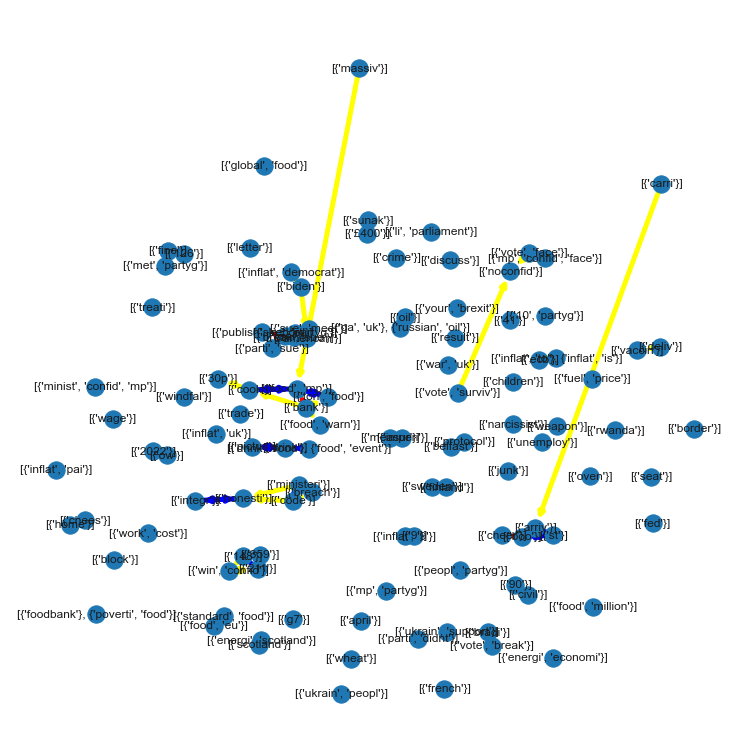

In [212]:
# # Draw the network as a graph
# from fa2 import ForceAtlas2

# plt.figure(figsize=(10,10))

# forceatlas2 = ForceAtlas2(
#     # Behavior alternatives
#     outboundAttractionDistribution=False,  # Dissuade hubs
#     linLogMode=False,  # NOT IMPLEMENTED
#     adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
#     edgeWeightInfluence=1.0,

#     # Performance
#     jitterTolerance=1.0,  # Tolerance
#     barnesHutOptimize=True,
#     barnesHutTheta=1.2,
#     multiThreaded=False,  # NOT IMPLEMENTED

#     # Tuning
#     scalingRatio=2.0,
#     strongGravityMode=False,
#     gravity=1.0,

#     # Log
#     verbose=True)

# positions = forceatlas2.forceatlas2_networkx_layout(narrative_G, pos=None, iterations=20)

# nx.draw(
#     narrative_G, 
#     pos=positions,
#     labels=nx.get_node_attributes(narrative_G, 'rule'),
#     edge_color=[narrative_G.edges[e]['relationship'] for e in narrative_G.edges],
#     #edge_cmap=plt.cm.Greys,
#     width=5,
#     #node_color=[block_A[n,n] for n in range(block_G.number_of_nodes())],
#     cmap=plt.cm.Greys
# )